In [17]:
import pandas as pd
from pathlib import Path
import tarfile
import urllib.request
import matplotlib.pyplot as plt
import numpy as np

In [19]:
def read_data():
    """
    Function to read housing.tgz from a url and decompress into housing.csv
    Returns a pandas DataFrame of the read file
    """
    tgz_path = Path("./housing.tgz")
    if not tgz_path.is_file():
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tgz_path)
        with tarfile.open(tgz_path) as tgz_file:
            tgz_file.extractall(path = ".") # decompress tgz file
    return pd.read_csv(Path("./housing/housing.csv"))

In [21]:
data = read_data()
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
None


In [23]:
print(data["ocean_proximity"].value_counts())
print()
print(data.describe())

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

          longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385

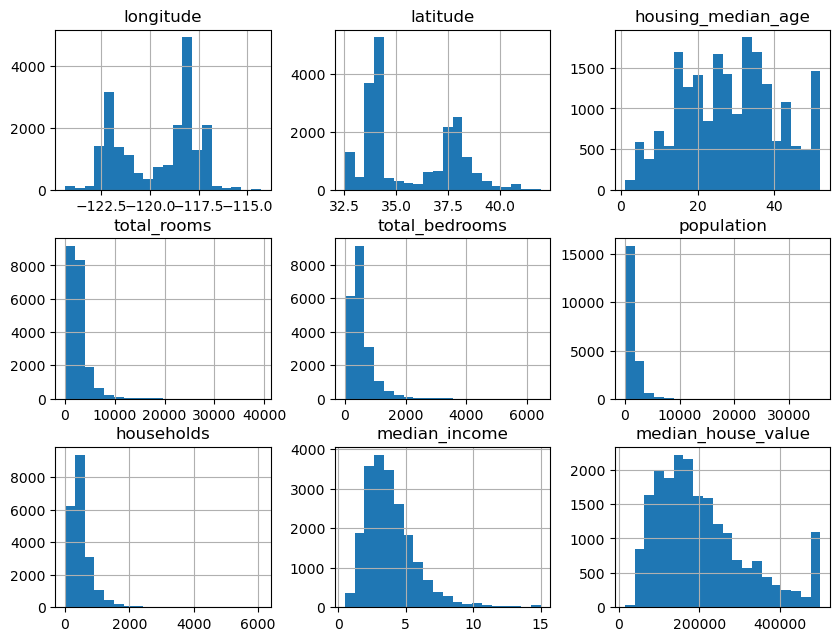

In [25]:
# plot histogram to better visualize data
data.hist(bins = 20, figsize = (10, 7.5))
plt.show()

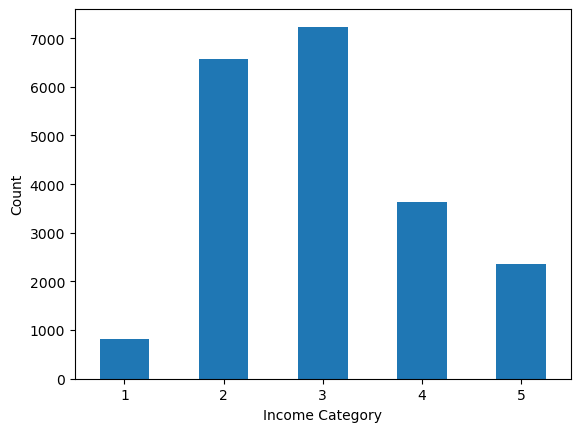

In [27]:
# stratify split by median income
data["income_category"] = pd.cut(data["median_income"],
                                 bins = [0, 1.5, 3, 4.5, 6, np.inf],
                                 labels = [1, 2, 3, 4, 5])
# visualize
data["income_category"].value_counts().sort_index().plot.bar(rot = 0)
plt.xlabel("Income Category")
plt.ylabel("Count")
plt.show()

In [31]:
from sklearn.model_selection import train_test_split
# split by strata (just using first split)
split_train, split_test = train_test_split(data, test_size = 0.2,
                                           stratify = data["income_category"], random_state = 42)
# can drop income category column because it was just a splitting tool
split_train.drop(columns = "income_category", inplace = True, errors = "ignore")
split_test.drop(columns = "income_category", inplace = True, errors = "ignore")

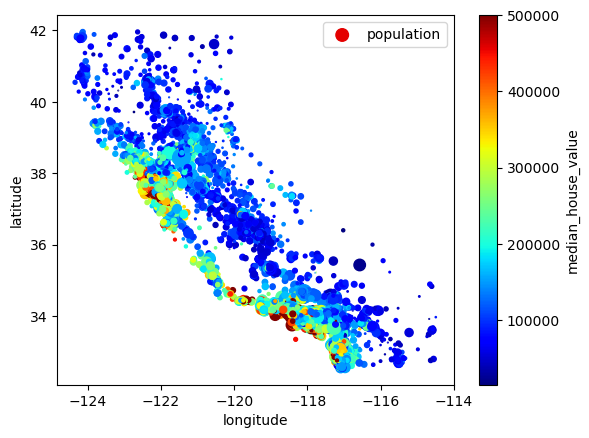

In [33]:
# visualize training data
# radius is population, color is median house value
split_train.plot(kind = "scatter", x = "longitude", y = "latitude",
                 s = split_train["population"] / 100, label = "population",
                 c = "median_house_value", cmap = "jet", colorbar = True,
                 legend = True, sharex = False)
plt.show()

In [35]:
# look for correlations
corr_matrix = split_train.corr(numeric_only = True)
print(corr_matrix["median_house_value"].sort_values(ascending = False))

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64


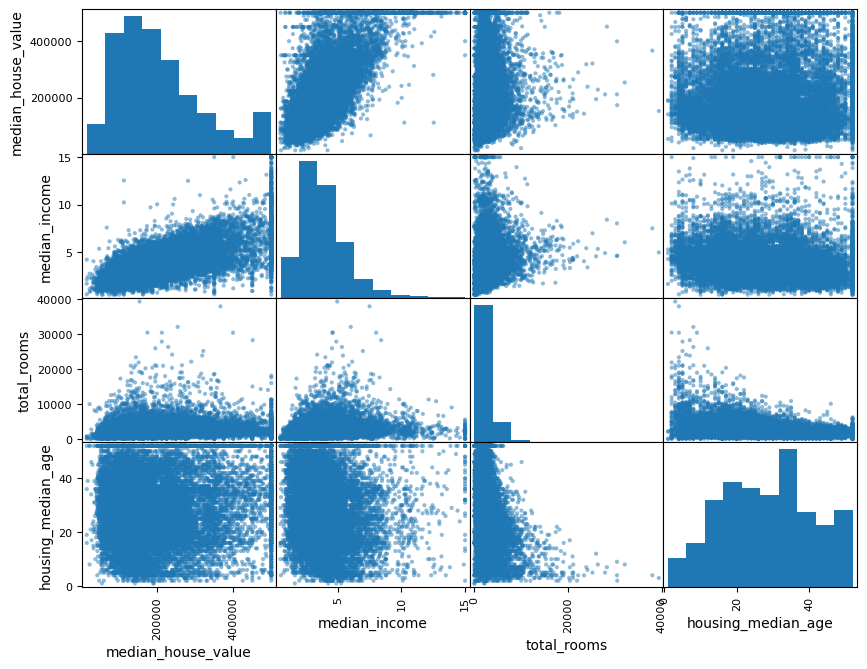

In [37]:
# graph the top 3 attributes with highest correlation to median house value
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
pd.plotting.scatter_matrix(split_train[attributes], figsize = (10, 7.5))
plt.show()

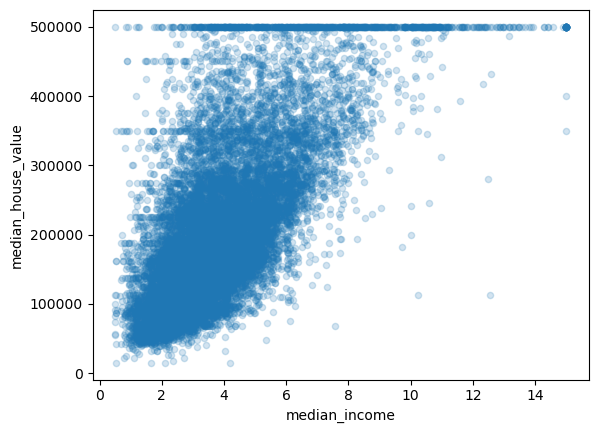

In [39]:
# median house value and median income have most obvious correlation
split_train.plot(kind = "scatter", x = "median_income", y = "median_house_value", alpha = 0.2)
plt.show()

In [41]:
# DO NOT RUN
imputer = SimpleImputer(strategy = "median")
num_training_data = split_train.select_dtypes(include = [np.number])
imputer.fit(num_training_data)
print(f"Stored medians:\n{imputer.statistics_}") # median of every numerical attribute
X = imputer.transform(num_training_data)
print(f"Total N/A values after transformation: {np.count_nonzero(np.isnan(X))}")

NameError: name 'SimpleImputer' is not defined

In [43]:
# DO NOT RUN
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [33]:
# DO NOT RUN
# encode ocean proximity (categorical column)
encoder = OneHotEncoder()
cat_train_encoded = encoder.fit_transform(split_train[["ocean_proximity"]])
print(encoder.categories_)

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


In [59]:
# create custom transformer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters = 10, gamma = 1, random_state = None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y = None, sample_weight = None):
        """
        Uses KMeans to identify the main clusters in the data
        """
        self.kmeans_ = KMeans(self.n_clusters, n_init = 10, random_state = self.random_state)
        self.kmeans_.fit(X, sample_weight = sample_weight)
        return self

    def transform(self, X):
        """
        Uses rbf_kernel to transform based on cluster similarity
        """
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma = self.gamma)

    def get_feature_names_out(self, names = None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [61]:
# create sklearn pipeline for preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# add ratio features bedrooms_ratio, rooms_per_house, people_per_house
def get_cols_ratio(X):
    return X[:, [0]] / X[:, [1]] # needs to return 2D array for transformer

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]

def ratio_pipeline():
    """
    Pipeline to first impute all missing values, get the desired ratio between two columns, then scale
    """
    return make_pipeline(SimpleImputer(strategy = "median"),
                         FunctionTransformer(get_cols_ratio, feature_names_out = ratio_name),
                         StandardScaler())

log_pipeline = make_pipeline(SimpleImputer(strategy = "median"),
                             FunctionTransformer(np.log, feature_names_out = "one-to-one"),
                             StandardScaler())

# add cluster similarity feature
cluster_similarity = ClusterSimilarity(n_clusters = 10, gamma = 1, random_state = 42)

# make pipelines for numerical and categorical columns
num_pipeline = make_pipeline(SimpleImputer(strategy = "median"), StandardScaler())
cat_pipeline = make_pipeline(SimpleImputer(strategy = "most_frequent"), OneHotEncoder(handle_unknown = "ignore"))

# put all pipelines together into column transformer
preprocessing = ColumnTransformer([("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
                                   ("rooms_per_household", ratio_pipeline(), ["total_rooms", "households"]),
                                   ("people_per_household", ratio_pipeline(), ["population", "households"]),
                                   ("log", log_pipeline, ["total_bedrooms", "total_rooms",
                                                          "population", "households", "median_income"]),
                                   ("geo", cluster_similarity, ["latitude", "longitude"]),
                                   ("cat", cat_pipeline, make_column_selector(dtype_include = object))],
                                  remainder = num_pipeline) # only col that remains is housing_median_age